# Double Exponential Smoothing Notes

Self Study - December 2021

Noah Rubin

### Overview

[Double Exponential Smoothing](https://online.stat.psu.edu/stat501/node/1001) (Holt's method) enhances simple exponential smoothing as it now caters for the existence of a trend component (but still no seasonality present) in a time series. A trend shows the movement of a a series from one point in time to another and is characterised by the slope. An additive trend grows or decays in linear fashion while a multiplicative trend will increase or decrease exponentially. 

A time series will consist of systematic components such as level, trend (slope) and seasonality but also the noise which represents the non-systemastic component. Thus a time series can be broken down using an additive model such that:

$$y_t = L_t + T_t + S_t + u_t$$

in which $L_t$ denotes level, $T_t$ denotes trend, $S_t$ denotes seasonality and $u_t$ is the error component. Each aspect is taken into account and then added together.

A multiplicative model would then follow the form

$$y_t = L_t \times T_t \times S_t \times u_t$$

in which the series gets decomposed into these various components but is then combined multiplicatively

---

### Forecasting equations

The way in which forecasting is done using an additive model is through the equation 

$$F_{t+k} = L_t + kT_t$$

in which $k$ (a constant) represents how far into the future we wish to forecast. Because there is no seasonality component, all future forecasts for double exponential smoothing will be according to a line with a non-changing slope. In the case of a multiplicative trend 

$$F_{t+k} = L_t \times (T_t)^k$$

whereby all future forecasts in this case will grow or decay monotonically. The level $L_t$ has its own equation whereby:

$$L_t = \alpha y_t + (1-\alpha)(L_{t-1} + T_{t-1})$$

which closely mirrors simple exponential smoothing and the idea of updating the current level using the current data point as well as the previous level. The difference here is that there is now a trend equation here, hence we essentially adjust the previous level by adding a trend. The trend equation updates the trend and is given as:

$$T_t = \beta(L_t - L_{t-1}) + (1-\beta)T_{t-1}$$

Here the trend is updated through taking into account the previous trend, but also the difference between the recent estimates of the level component. This ultimately allows the trend to change at different periods in time. The smoothing constant $\beta$ is a hyperparameter that controls the speed in which the trend is adjusted. If rapid changes in the trend occur, it would be nice to have the algorithm learn the trend faster, and this is what $\beta$ assists with.

---

### Setting smoothing constants $\alpha$ and $\beta$

Parameters, $\alpha$ and $\beta$ can be chosen based off the minimisation of a loss function such as mean squared error or metrics such as root mean squared error, MAPE etc. when considering the training set. This can potentially cause overfitting problems and poor performance on out of sample data, but isn't always the case. Setting $\alpha$ and $\beta$ ultimately depends on domain expertise and the specific problem at hand. The value for $\alpha$ and $\beta$ will lie in the interval (0, 1]

---

### Holt's method when there is seasonality

Double exponential smoothing performs best when there is no seasonal component to the time series. However, for cases where seasonality is present, one can:
* Remove the seasonality through deseasonalising (seasonal adjustment)
* Run Holt's exponential smoothing on the deseasonalised series to generate predictions/forecasts
* Reseasonalise through reversing the process of the seasonal adjustment 

---



# Code: NDQ ETF High Prices

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'


In [2]:
df = yf.Ticker('NDQ.AX').history(period='max')

# Select a few interesting columns to explore and set the frequency to business days
df = df[['Open', 'High', 'Low', 'Close']].asfreq('B')

# For missing values (public holidays etc) 
# ... `ffill()` ensures NaN values are filled based on the row above (i.e previous row)
df.fillna(method='ffill', inplace=True)

#### Plot the data

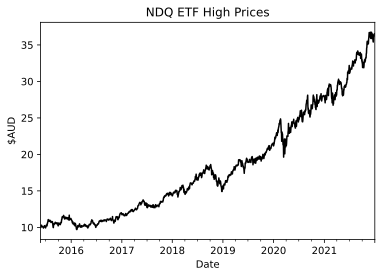

In [3]:
df['High'].plot(color='black', title='NDQ ETF High Prices', ylabel='$AUD');

#### Split Dataset into train and test sets

Will be basing forecasts based off the high price series

In [4]:
train, test = temporal_train_test_split(df.High, train_size=0.8)

#### Apply double exponential smoothing to the time series

Documentation [here](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html), [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit) and [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.HoltWintersResults.html#statsmodels.tsa.holtwinters.HoltWintersResults) (in that order)

* Will be using an additive model rather than multiplicative (`exponential=False`)
* Setting $\alpha$ and $\beta$ to a default value of 0.3

In [5]:
forecaster = Holt(endog=train, exponential=False, initialization_method='estimated').fit(smoothing_level=0.3, smoothing_trend=0.3)
print(forecaster.summary())

                              Holt Model Results                              
Dep. Variable:                   High   No. Observations:                 1379
Model:                           Holt   SSE                             92.617
Optimized:                       True   AIC                          -3716.191
Trend:                       Additive   BIC                          -3695.275
Seasonal:                        None   AICC                         -3716.130
Seasonal Periods:                None   Date:                 Sat, 01 Jan 2022
Box-Cox:                        False   Time:                         12:52:26
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000                alpha                False
smoothing_trend            0.3000000                

#### Summary Plot

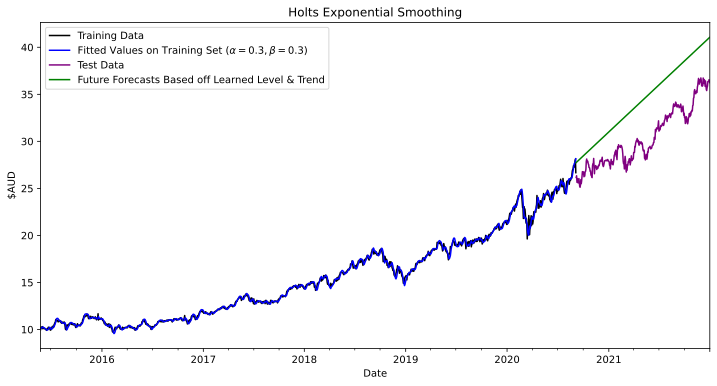

In [6]:
#### Plot fitted values with training data

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set(title='Holts Exponential Smoothing', ylabel='$AUD')

# Plot training set 
train.plot(ax=ax1, color='black', label='Training Data')

# Plot double expomnential smoothing fitted values
forecaster.fittedvalues.plot(ax=ax1, color='blue', label=r'Fitted Values on Training Set ($\alpha=0.3, \beta=0.3$)');

# =============================================================

#### Plot forecasts with test set

# Plot test set
test.plot(ax=ax1, color='purple', label='Test Data')

# Plot forecasts (even though bthey are way off)
yhat = forecaster.forecast(len(test))
yhat.plot(ax=ax1, color='green', label='Future Forecasts Based off Learned Level & Trend');

# Set up legend
ax1.legend();